# EOLES_elecRES in Julia

[EOLES_elecRES](https://github.com/BehrangShirizadeh/EOLES_elecRES) ported to Julia, with the [JuMP]() package.

Precisely: EOLES_elecRES.gms

PH, Feb 2021

In [39]:
using CSV, DataFrames, PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


## Model data

### Sets

#### hours and months

sets `h /0*8759/`

         first(h)        'first hour'
         last(h)         'last hour'
         
         first(h) = ord(h)=1;
last(h) = ord(h)=card(h);

alias(h,hh);

In [2]:
h = 0:8759

0:8759

In [3]:
m = [:jan, :feb, :mar, :apr, :may, :jun, :jul, :aug, :sep, :oct, :nov, :dec]

12-element Array{Symbol,1}:
 :jan
 :feb
 :mar
 :apr
 :may
 :jun
 :jul
 :aug
 :sep
 :oct
 :nov
 :dec

#### technology sets

All technologies

In [4]:
tec = [:offshore, :onshore, :pv, :river, :lake, :biogas, :gas, :phs, :battery, :methanation] 

10-element Array{Symbol,1}:
 :offshore
 :onshore
 :pv
 :river
 :lake
 :biogas
 :gas
 :phs
 :battery
 :methanation

Subsets of `tec`

In [8]:
str

UndefVarError: UndefVarError: str not defined

In [10]:
# power plants
gen = [:offshore, :onshore, :pv, :river, :lake, :biogas, :gas]
# variable tecs
vre = [:offshore, :onshore, :pv]
# non-combustible generation
ncomb = [:offshore, :onshore, :pv, :river, :lake, :phs, :battery]
# combustible generation techs
comb = [:biogas, :methanation] # Q: is it a bug. Should it be biogas and gas?
# storage technologies
str = [:phs, :battery, :methanation]
# technologies for upward FRR
frr = [:lake, :phs, :battery, :gas];

### Parameters

Original GAMS definition for months:
```
parameter month(h)  /0*743 1, 744*1439 2, 1440*2183 3, 2184*2903 4
                    2904*3647 5, 3648*4367 6, 4368*5111 7, 5112*5855 8
                    5856*6575 9, 6576*7319 10, 7320*8039 11, 8040*8759 12/
```

observe that February has 29 days, which is compensated by December having only 30:

In [35]:
(1439 - 744 +1)/24, (8759 - 8040 +1)/24

(29.0, 30.0)

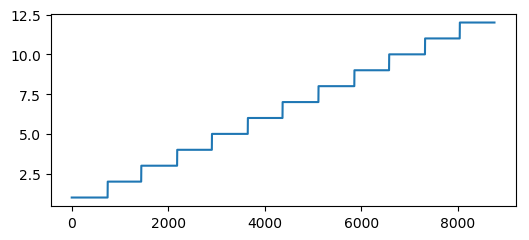

In [42]:
month = [
     repeat([1], 31*24);  repeat([2], 29*24);  repeat([3], 31*24);  repeat([4], 30*24);
     repeat([5], 31*24);  repeat([6], 30*24);  repeat([7], 31*24);  repeat([8], 31*24);
     repeat([9], 30*24); repeat([10], 31*24); repeat([11], 30*24); repeat([12], 30*24)
]

figure(figsize=(6,2.5))
plot(h, month);

parameter `load_factor(vre,h)` 'Production profiles of VRE'

from file `inputs/vre_profiles2006.csv`

In [55]:
load_factor = DataFrame(CSV.File("inputs/vre_profiles2006.csv", header=["vre", "hour", "cf"]))
load_factor[1:5,:]

,vre,hour,cf
,String,Int64,Float64
1,offshore,0,0.865143
2,offshore,1,0.88
3,offshore,2,0.88
4,offshore,3,0.873429
5,offshore,4,0.852


In [56]:
load_factor_wide = unstack(load_factor, :hour, :vre, :cf)
load_factor_wide[1:5,:]

,hour,offshore,onshore,pv
,Int64,Float64?,Float64?,Float64?
1,0,0.865143,0.511702,0.0
2,1,0.88,0.52791,0.0
3,2,0.88,0.537973,0.0
4,3,0.873429,0.541571,0.0
5,4,0.852,0.538737,0.0


In [57]:
size(load_factor), size(load_factor_wide)

((26280, 3), (8760, 4))

Notice that the data type is `Union{Missing, Float64}` rather than `Float64`. Are there missing bits? Answer: no. Counting gives 0, and conversion to Float64 does not fail.

In [58]:
load_factor_wide.offshore[1:5]

5-element Array{Union{Missing, Float64},1}:
 0.865142857
 0.88
 0.88
 0.873428571
 0.852

In [59]:
length(findall(x -> ismissing(x), load_factor_wide.pv))

0

In [60]:
load_factor = convert(Matrix{Float64}, load_factor_wide[:,2:end])'
load_factor

3×8760 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.865143  0.88     0.88      0.873429  …  0.990286  0.991     0.988143
 0.511702  0.52791  0.537973  0.541571     0.826158  0.825222  0.818481
 0.0       0.0      0.0       0.0          0.0       0.0       0.0

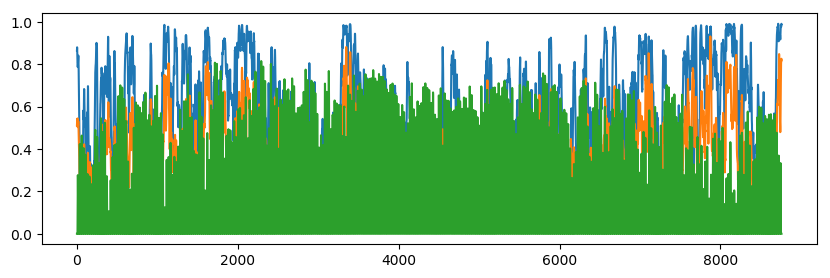

In [64]:
figure(figsize=(10, 3))
plot(h, load_factor')
tight_layout;

Parameter `demand(h)` 'demand profile in each hour in GW'

from file `inputs/demand2050_ademe.csv`

In [49]:
df = DataFrame(CSV.File("inputs/demand2050_ademe.csv", header=["hour", "demand"]))
demand = convert(Vector, df[:,2]);

8760-element Array{Float64,1}:
 28.6900142
 31.2084578
 27.6996061
 27.9874884
 28.1626729
 28.0213627
 29.0016469
 27.7816746
 31.1353806
 37.2348662
 40.0628793
 43.6825651
 46.7337019
  ⋮
 46.2840474
 45.3514373
 39.8355295
 35.6773985
 32.6176733
 33.4135223
 35.53334
 38.6087921
 39.3380623
 36.7066712
 33.2898536
 28.6056381

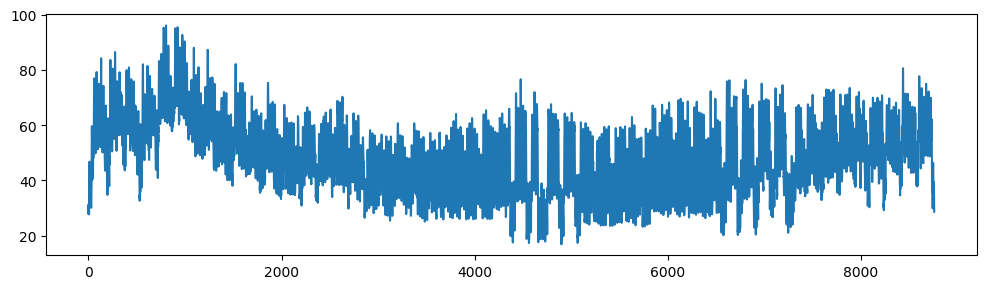

In [54]:
figure(figsize=(10, 3))
plot(h, demand)
tight_layout()

In [ ]:
Parameter lake_inflows(m) 'monthly lake inflows in GWh'

$ondelim
$include  inputs/lake_inflows.csv
$offdelim
/ ;

In [ ]:
parameter gene_river(h) 'hourly run of river power generation in GWh'
/
$ondelim
$include  inputs/run_of_river.csv
$offdelim
/ ;

In [ ]:
parameter epsilon(vre) 'additional FRR requirement for variable renewable energies because of forecast errors'
/
$ondelim
$include  inputs/reserve_requirements.csv
$offdelim
/ ;

In [ ]:
parameter capa_ex(tec) 'existing capacities of the technologies by December 2017 in GW'
/
$ondelim
$include  inputs/existing_capas.csv
$offdelim
/ ;

In [ ]:
parameter capa_max(tec) 'maximum capacities of the technologies in GW'
/
$ondelim
$include  inputs/max_capas.csv
$offdelim
/ ;

In [ ]:
parameter capex(tec) 'annualized power capex cost in M€/GW/year'
/
$ondelim
$include  inputs/annuities.csv
$offdelim
/ ;

In [ ]:
parameter capex_en(str) 'annualized energy capex cost of storage technologies in M€/GWh/year'
/
$ondelim
$include  inputs/str_annuities.csv
$offdelim
/ ;

In [ ]:
parameter fOM(tec) 'annualized fixed operation and maintenance costs M€/GW/year'
/
$ondelim
$include  inputs/fO&M.csv
$offdelim
/ ;

In [ ]:
Parameter vOM(tec) 'Variable operation and maintenance costs in M€/GWh'
/
$ondelim
$include  inputs/vO&M.csv
$offdelim
/ ;

```gams
parameter s_capex(str) 'charging related annuity of storage in M€/GW/year' /PHS 0, battery 0, methanation 84.16086/;
parameter s_opex(str)    'charging related fOM of storage in M€/GW/year'   /PHS 0, battery 0, methanation 59.25/;
parameter eta_in(str) 'charging efifciency of storage technologies' /PHS 0.95, battery 0.9, methanation 0.59/;
parameter eta_out(str) 'discharging efficiency of storage technolgoies' /PHS 0.9, battery 0.95, methanation 0.45/;
scalar pump_capa 'pumping capacity in GW' /9.3/;
scalar max_phs 'maximum volume of energy can be stored in PHS reservoir in TWh' /0.18/;
scalar max_biogas 'maxium energy can be generated by biogas in TWh' /15/;
scalar load_uncertainty 'uncertainty coefficient for hourly demand' /0.01/;
scalar delta 'load variation factor'     /0.1/;
parameter fixed_costs(tec) 'yearly fixed cost of each tec in M€/GW/year' ;
fixed_costs(tec) = capex(tec) + fOM(tec);
```

## Model

### Variables

```
variables        GENE(tec,h)     'hourly energy generation in TWh'
                 CAPA(tec)       'overal yearly installed capacity in GW'
                 STORAGE(str,h)  'hourly electricity input of battery storage GW'
                 S(str)          'charging power capacity of each storage technology'
                 STORED(str,h)   'energy stored in each storage technology in GWh'
                 CAPACITY(str)   'energy volume of storage technologies in GWh'
                 RSV(frr,h)      'required upward frequency restoration reserve in GW'
                 COST            'final investment cost in b€'

positive variables GENE(tec,h),CAPA(tec),STORAGE(str,h), S(str),STORED(str,h),CAPACITY(str),RSV(frr,h);
```

### Equations

```
equations        gene_vre        'variables renewable profiles generation'
                 gene_capa       'capacity and genration relation for technologies'
                 combustion      'the relationship of combustible technologies'
                 capa_frr        'capacity needed for the secondary reserve requirements'
                 storing         'the definition of stored energy in the storage options'
                 storage_const   'storage in the first hour is equal to the storage in the last hour'
                 lake_res        'constraint on water for lake reservoirs'
                 stored_cap      'maximum energy that is stored in storage units'
                 storage_capa1   'the capacity with hourly charging relationship of storage'
                 storage_capa2   'storage power limit'
                 biogas_const    'maximum energy can be produced by biogas'
                 reserves        'FRR requirement'
                 adequacy        'supply/demand relation'
                 obj             'the final objective function which is COST';

gene_vre(vre,h)..                GENE(vre,h)             =e=     CAPA(vre)*load_factor(vre,h);
gene_capa(tec,h)..               CAPA(tec)               =g=     GENE(tec,h);
combustion(h)..                  GENE('gas',h)           =e=     sum(comb,GENE(comb,h));
capa_frr(frr,h)..                CAPA(frr)               =g=     GENE(frr,h) + RSV(frr,h);
storing(h,h+1,str)..             STORED(str,h+1)         =e=     STORED(str,h) + STORAGE(str,h)*eta_in(str) - GENE(str,h)/eta_out(str);
storage_const(str,first,last)..  STORED(str,first)       =e=     STORED(str,last)+STORAGE(str,last)*eta_in(str)-GENE(str,last)/eta_out(str);
lake_res(m)..                    lake_inflows(m)         =g=     sum(h$(month(h) = ord(m)),GENE('lake',h))/1000;
stored_cap(str,h)..              STORED(str,h)           =l=     CAPACITY(str);
storage_capa1(str,h)..           S(str)                  =g=     STORAGE(str,h);
storage_capa2(str)..             S(str)                  =l=     CAPA(str);
biogas_const..                   sum(h,GENE('biogas',h)) =l=     max_biogas*1000;
reserves(h)..                    sum(frr, RSV(frr,h))    =e=     sum(vre,epsilon(vre)*CAPA(vre))+ demand(h)*load_uncertainty*(1+delta);
adequacy(h)..                    sum(ncomb,GENE(ncomb,h))+GENE('gas',h)    =g=     demand(h)+sum(str,STORAGE(str,h)) ;
obj..                            COST                    =e=     (sum(tec,(CAPA(tec)-capa_ex(tec))*capex(tec))+ sum(str,CAPACITY(str)*capex_en(str))+sum(tec,(CAPA(tec)*fOM(tec)))+ sum(str,S(str)*(s_capex(str)+s_opex(str))) + sum((tec,h),GENE(tec,h)*vOM(tec)))/1000;
```